In [1]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize(project="ee-sentinel-analysis")

Collection : https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD

==============================================================================================================   
##### **SEPARATION VV / VH**  
==============================================================================================================

In [4]:
# Load the Sentinel-1 ImageCollection, filter to Jun-Sep 2020 observations.
sentinel_1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterDate(
    '2020-10-01', '2020-10-02'
)

# Filter the Sentinel-1 collection by metadata properties.
vv_vh_iw = (
    sentinel_1.filter(
        # Filter to get images with VV and VH dual polarization.
        ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')
    )
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    .filter(
        # Filter to get images collected in interferometric wide swath mode.
        ee.Filter.eq('instrumentMode', 'IW')
    )
)

# Separate ascending and descending orbit images into distinct collections.
vv_vh_iw_asc = vv_vh_iw.filter(
    ee.Filter.eq('orbitProperties_pass', 'ASCENDING')
)
vv_vh_iw_desc = vv_vh_iw.filter(
    ee.Filter.eq('orbitProperties_pass', 'DESCENDING')
)

# Calculate temporal means for various observations to use for visualization.
vh_iw_asc_mean = vv_vh_iw_asc.select('VH').mean() # Mean VH ascending.
vh_iw_desc_mean = vv_vh_iw_desc.select('VH').mean() # Mean VH descending.
vv_iw_asc_desc_mean = vv_vh_iw_asc.merge(vv_vh_iw_desc).select('VV').mean() # Mean VV for combined ascending and descending image collections.
vh_iw_asc_desc_mean = vv_vh_iw_asc.merge(vv_vh_iw_desc).select('VH').mean() # Mean VH for combined ascending and descending image collections.

# Display the temporal means for various observations, compare them.
m = geemap.Map()
m.add_layer(vv_iw_asc_desc_mean, {'min': -12, 'max': -4}, 'vv_iw_asc_desc_mean')
m.add_layer(vh_iw_asc_desc_mean, {'min': -18, 'max': -10}, 'vh_iw_asc_desc_mean')
m.add_layer(vh_iw_asc_mean, {'min': -18, 'max': -10}, 'vh_iw_asc_mean')
m.add_layer(vh_iw_desc_mean, {'min': -18, 'max': -10}, 'vh_iw_desc_mean')

beauvais_roi = [
    [2.470013829667166, 48.49155618695181],
    [2.4864504065104276, 48.49155618695181],
    [2.4864504065104276, 48.49718725242921],
    [2.470013829667166, 48.49718725242921],
    [2.470013829667166, 48.49155618695181]
]

# Calculate the centroid (average of lat and lon)
centroid_lon = sum([coord[0] for coord in beauvais_roi]) / len(beauvais_roi)
centroid_lat = sum([coord[1] for coord in beauvais_roi]) / len(beauvais_roi)

# Set the map center using the calculated centroid
m.setCenter(centroid_lon, centroid_lat, zoom=15)

# Add the polygon to the map as a layer
style = {
    'color': 'red',           # Border color
    'fillColor': '00000000',  # Fill color (transparent)
    'width': 3                # Border width
}
polygon_roi = ee.Geometry.Polygon(beauvais_roi)
m.addLayer(polygon_roi, style, "Beauvais")

m

Map(center=[48.49380861314277, 2.4765884604044706], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
# Load the Sentinel-1 ImageCollection, filter to October 1, 2020.
sentinel_1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterDate(
    '2020-10-01', '2020-10-02'
)

# Filter the Sentinel-1 collection by metadata properties.
vv_vh_iw = (
    sentinel_1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
              .filter(ee.Filter.eq('instrumentMode', 'IW'))
)

# Separate ascending and descending orbit images into distinct collections.
vv_vh_iw_asc = vv_vh_iw.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
vv_vh_iw_desc = vv_vh_iw.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

# Calculate temporal means for the selected date range (here, it's just one day).
vv_image = vv_vh_iw.select('VV').mean()  # Mean VV for the day
vh_image = vv_vh_iw.select('VH').mean()  # Mean VH for the day

# Define the region of interest (Beauvais ROI).
beauvais_roi = [
    [2.470013829667166, 48.49155618695181],
    [2.4864504065104276, 48.49155618695181],
    [2.4864504065104276, 48.49718725242921],
    [2.470013829667166, 48.49718725242921],
    [2.470013829667166, 48.49155618695181]
]
polygon_roi = ee.Geometry.Polygon(beauvais_roi)

# Set visualization parameters for VV and VH.
vv_vis_params = {'min': -12, 'max': -4, 'palette': ['blue', 'white', 'green']}
vh_vis_params = {'min': -18, 'max': -10, 'palette': ['purple', 'white', 'yellow']}

# Create a geemap map.
m = geemap.Map(center=[48.494, 2.478], zoom=15)
m.addLayer(vv_image.clip(polygon_roi), vv_vis_params, 'VV Image')
m.addLayer(vh_image.clip(polygon_roi), vh_vis_params, 'VH Image')
m.addLayer(polygon_roi, {'color': 'red'}, "Beauvais ROI")
m


Map(center=[48.494, 2.478], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [6]:
# Export VV and VH images as TIF
vv_tif_path = 'vv_image.tif'
vh_tif_path = 'vh_image.tif'

# Export the images as GeoTIFF files.
geemap.ee_export_image(vv_image, filename=vv_tif_path, scale=10, region=polygon_roi)
geemap.ee_export_image(vh_image, filename=vh_tif_path, scale=10, region=polygon_roi)


Generating URL ...
Please wait ...
Data downloaded to c:\Users\aymer\Documents\AERO5\PMI\PMI_detection_TillageLabour\Datasets\vv_image.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\aymer\Documents\AERO5\PMI\PMI_detection_TillageLabour\Datasets\vh_image.tif


Image PNG créée avec succès.


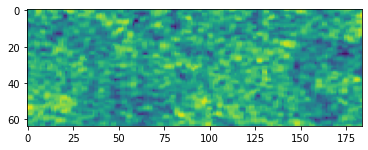

In [7]:
import cv2

tif_path = "vv_image.tif"  # Remplacez par le chemin réel de votre fichier TIFF

img = cv2.imread(tif_path , cv2.IMREAD_ANYDEPTH)
if img is None:
    print("Erreur lors de la lecture de l'image.")
else:
    # Normaliser l'image pour la convertir en 8 bits
    img_min = img.min()
    img_max = img.max()

    # Évitez la division par zéro
    if img_max > img_min:
        img_normalized = ((img - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    else:
        img_normalized = np.zeros(img.shape, dtype=np.uint8)  # Créez une image noire si toutes les valeurs sont identiques

    # Enregistrer l'image normalisée en tant que PNG
    cv2.imwrite('vv_image_normalized.png', img_normalized)

    print("Image PNG créée avec succès.")
# Afficher l'image
plt.imshow(img)

# Enregistrer l'image en PNG si nécessaire
# plt.savefig('output_image.png')

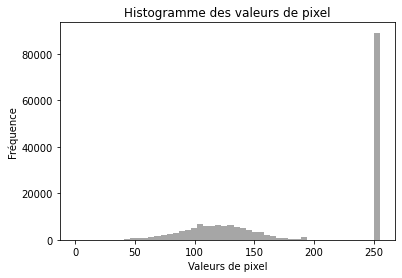

In [8]:
# =========================================================
# UTILISATION DU GETTHUMB
# =========================================================

import requests
import ee
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# Initialisation de Earth Engine
ee.Initialize()

# Charger l'image et la région d'intérêt
vv_image = ee.ImageCollection('COPERNICUS/S1_GRD').filterDate('2020-10-01', '2020-10-02') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')).select('VV').mean()

polygon_roi = ee.Geometry.Polygon([
    [2.470013829667166, 48.49155618695181],
    [2.4864504065104276, 48.49155618695181],
    [2.4864504065104276, 48.49718725242921],
    [2.470013829667166, 48.49718725242921],
    [2.470013829667166, 48.49155618695181]
])

# Télécharger les pixels en tant que tableau
url = vv_image.clip(polygon_roi).getThumbURL({
    'min': -20,
    'max': -0,
    'dimensions': 512,
    'region': polygon_roi,
    'format': 'png'
})

# Récupérer et sauvegarder l'image en PNG
response = requests.get(url, stream=True)
with open("vv_image.png", 'wb') as file:
    file.write(response.content)

# Afficher l'image avec Matplotlib
img = Image.open("vv_image.png")
img_array = np.array(img)

# Afficher l'histogramme
plt.hist(img_array.flatten(), bins=50, color='gray', alpha=0.7)
plt.title("Histogramme des valeurs de pixel")
plt.xlabel("Valeurs de pixel")
plt.ylabel("Fréquence")
plt.show()